In [1]:
##### Using Measurements to Calcuate Error in Local Clock Time for Nodes #####

####################
# IMPORT LIBRARIES #
####################

import numpy as np
from colorama import Fore, Style
import matplotlib.pyplot as plt
import math
import itertools

import json
from scipy import signal, stats
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)

In [2]:
####################
# DEFINE FUNCTIONS #
####################

def make_delta(col_num, links):
    file_name = "col_" + str(col_num) + ".txt"
    d = 0
    delta = np.zeros((len(links),1))

    with open(file_name,'r') as f:
        vals = f.readlines()
    
    for val in vals:
        val = val.replace(",\n", "")
        delta[d] = (int(val))
        d += 1
    return delta

def make_snr_vecs(col_num, links):
    file_name = "snr_" + str(col_num) + ".txt"
    sv = 0
    snr_vec = np.zeros((len(links),1))

    with open(file_name,'r') as f:
        vals = f.readlines()
    
    for val in vals:
        val = val.replace(",\n", "")
        snr_vec[sv] = val
        sv += 1
    return snr_vec

def find_e_vector(delta, pinvA, rx_names):
    estimate = np.dot(pinvA, delta)

    e_est = estimate[:len(rx_names)]
    T_est = estimate[len(rx_names):]
    return e_est, T_est, estimate

def print_results(col_num, rx_names, e_est, T_est):
    print(" ---------- column (repNum) " + str(col_num) + " in delta data ---------- ")
    print(Fore.RED + "(~, rx_name ) -----    e_estimate    -----   T_estimate" + Style.RESET_ALL)
    r = 0

    for rx in rx_names:
        rx_temp = rx
        if len(rx) != len("browning"):
            for i in range(len("browning")-len(rx)):
                rx_temp += " "
        if e_est[r][0] < 0 or T_est[r][0] < 0:
            print("(~, " + rx_temp + ") -----  [" + format(e_est[r][0],'.7f') + "]  ----- [" + 
                  format(T_est[r][0],'.7f') + ']')
        else:
            print("(~, " + rx_temp + ") -----  [" + format(e_est[r][0],'.8f') + "]  ----- [" + 
                  format(T_est[r][0],'.8f') + ']')
        r += 1

def least_sq_error(col_num, estimate, delta, A, links):
    # error / noise calculation for each link
    est_delta = np.dot(A,estimate)
    error = abs(delta - est_delta)
    
    i = np.array([*range(len(links))]).reshape(len(links),1)
    
    # plotting error for each link
    print(' ----- Plotting Link Error for Column ' + str(col_num) + ' ----- ')
    plt.plot(i,error)
    plt.grid()
    plt.xlabel('Link Number')
    plt.ylabel('Delta Estimation Error (Noise)')
    plt.title('Estimation Error/Noise by Link for Column ' + str(col_num))
    plt.show()
    
    # plotting histogram of error for each link
    print(' ----- Histogram Link error for Column ' + str(col_num) + ' ----- ')
    plt.hist(error)
    plt.grid()
    plt.xlabel('Delta Estimation Error (Noise)')
    plt.title('Histogram of Estimation Error for Column ' + str(col_num))
    plt.show()
    
    # plotting histogram of MSE for each link
    print(' ----- Histogram Link Squared Error for Column ' + str(col_num) + ' ----- ')
    plt.hist(np.square(error))
    plt.grid()
    plt.xlabel('Delta Estimation Error (Noise)')
    plt.title('Histogram of Squared Estimation Error for Column ' + str(col_num))
    plt.show()
    
    # finding root mean squared error for repNum (col_num)
    print(' ----- Root Mean Squared Error for Column ' + str(col_num) + ' ----- ')
    RMSE = math.sqrt(np.square(error).mean())
    print(RMSE)
    print('\n')
    return RMSE

def w_least_sq_error(col_num, estimate, delta, snr, A, links):
    # error / noise calculation for each link
    est_delta = np.dot(A,estimate)
    error = abs(delta - est_delta)
    w_error = np.multiply(error,snr)
    
    i = np.array([*range(len(links))]).reshape(len(links),1)
    
    # plotting w_error for each link
    print(' ----- Plotting Link Weighted Error for Column ' + str(col_num) + ' ----- ')
    plt.plot(i,w_error)
    plt.grid()
    plt.xlabel('Link Number')
    plt.ylabel('Delta Estimation Weighted Error (Noise)')
    plt.title('Estimation Weighted Error/Noise by Link for Column ' + str(col_num))
    plt.show()
    
    # plotting histogram of w_error for each link
    print(' ----- Histogram Link weighted error for Column ' + str(col_num) + ' ----- ')
    plt.hist(w_error)
    plt.grid()
    plt.xlabel('Delta Estimation Weighted Error (Noise)')
    plt.title('Histogram of Estimation Weighted Error for Column ' + str(col_num))
    plt.show()
    
    # plotting histogram of WMSE for each link
    print(' ----- Histogram Link Squared Weighted Error for Column ' + str(col_num) + ' ----- ')
    plt.hist(np.square(w_error))
    plt.grid()
    plt.xlabel('Delta Estimation Weighted Error (Noise)')
    plt.title('Histogram of Squared Estimation Weighted Error for Column ' + str(col_num))
    plt.show()
    
    # finding root weighted mean squared error for repNum (col_num)
    print(' ----- Root Mean Squared Weighted Error for Column ' + str(col_num) + ' ----- ')
    RMSE = math.sqrt(np.square(w_error).mean())
    print(RMSE)
    print('\n')
    return RMSE

def round_string(RMSE):
    round_i = 6
    while(len(str(RMSE)) > len('column #')):
        RMSE = round(RMSE,round_i)
        round_i -= 1
    return RMSE

def correct_difference(col_num, delta, rx_names, off):
    s = 0
    limit = len(rx_names)-1
    while s < len(rx_names):
        section = delta[s*(len(rx_names)-1):(s+1)*(len(rx_names)-1)]
        small = []
        lag_ind = 0
        for lag in section:
            ind = 0
            while(ind < limit):
                if abs(lag - section[ind]) > 2000:
                    min_val = min(lag, section[ind])[0]
                    if min_val == lag:
                        small.append([lag_ind,min_val])
                    else:
                        small.append([ind,min_val])
                ind += 1
            lag_ind += 1
        
        small.sort()
        small = list(small for small,_ in itertools.groupby(small))
        for sm in small:
            print('Column '+str(col_num)+', Section '+str(s)+', Index '+str(sm[0])+' -- '+str(sm[1]))
            delta[(sm[0] + s*limit)] += off # 4072, 4096
        s += 1
    return delta


In [3]:
####################
# DEFINE FUNCTIONS #
####################

def get_time_string(timestamp):
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

def JsonLoad(folder, json_file):
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes

def traverse_dataset(meas_folder):
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r")
    for cmd in dataset.keys():
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("Time Collected:", get_time_string(cmd_time))
            print("Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("Time Collected:", get_time_string(cmd_time))
            print("Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))
        else:                       
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc

def plotOnePSDForEachLink(rx_data, txrxloc, samp_rate=250000, repNums=4):
    for txname in rx_data:
        for i in range(0, len(rx_data[txname]), repNums):
            plt.figure()
            plt.psd(rx_data[txname][i][0], Fs = samp_rate/1000)
            plt.ylim(-110, -60)
            plt.yticks(ticks=[-110, -100, -90, -80, -70, -60])
            plt.grid('on')
            plt.title('TX: {} RX: {}'.format(txname, txrxloc[txname][i]))
            plt.xlabel('Frequency (kHz)')
            plt.tight_layout()
            plt.show()

def calculate_SNR(rx_data, samp_rate=250000):
    Pxx, freqs = plt.psd(rx_data, Fs = samp_rate/1000)
    for i in range(len(Pxx)):
        Pxx[i] = 10*math.log10(Pxx[i]) # put Pxx in dB
    
    center_ind = int(len(Pxx)/2)
    lower = center_ind - 25
    upper = center_ind + 25
        
    s = max(Pxx[lower:upper]) # signal
    n = max(np.hstack((Pxx[:lower], Pxx[upper:]))) # noise
    snr = 1 - (s/n)
    return snr

In [4]:
####################
# DEFINE FUNCTIONS #
####################

def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                output[k] = outputVec[i]
    return output

def oversample(x, OS_Rate):
    x_s = np.zeros(len(x)*OS_Rate)
    x_s[::OS_Rate] = x
    return x_s

def SRRC(alpha, N, Lp):
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

def binary2mary(data, M):
    log2M   = round(np.log2(M))
    if (len(data) % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    data.shape = (len(data)//log2M, log2M)
    binaryValuesArray = 2**np.arange(log2M)
    marydata = data.dot(binaryValuesArray)
    return marydata

def createPreambleSignal(A, N, alpha, Lp):
    preamble = np.tile([1, 1, 0, 0], 16)
    data = binary2mary(preamble, 4)

    # Modulation
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    # Upsample
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    # Pulse-shape filter
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')
    
    return (s_0_I + 1j*s_0_Q), pulse

def crossCorrelationMax(rx0, preambleSignal, peaks_arr):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='same')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)
    
    length_of_packet = 3200
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    
    # Calculate length of packet
    peak_1 = lags[np.argmax(xcorr_mag)]
    short_xcorr_mag = np.concatenate((xcorr_mag[:peak_1-300], xcorr_mag[peak_1+300:]))
    peak_2 = np.argmax(short_xcorr_mag)
    if peak_2 > peak_1-300:
        peak_2 += 300
    peak_2 = lags[peak_2]
    peaks = np.array([peak_1,peak_2])
    peaks_arr.append(abs(peak_1-peak_2))
    
#     plt.figure()
#     plt.plot(lags, xcorr_mag, label='|X-Correlation|')
#     plt.legend()
#     plt.plot(peaks, xcorr_mag[peaks], "x")
#     plt.ylabel('|X-Correlation|', fontsize=14)
#     plt.xlabel('Sample Index', fontsize=14)
#     plt.tight_layout()
    
    return lagIndex

In [5]:
####################
# LOADING DATA     #
####################

# Load parameters from the JSON file which describe what was measured
# Note: If repNum (rxrepeat) != 4, this script will only calculate for the first 4
#       This can be edited by adding more iterations in each section, starting at MAKE DELTA VECS

# =================================================================== #
# =================== Choose Data Set =============================== #
# =================================================================== #

print(' ----- Data for ----- Feb 16 ----- data collection ----- \n')
folder = "Shout_meas_02-16-2023_01-27-48"

# print(' ----- Data for ----- Jan 20 ----- data collection ----- \n')
# folder = "Shout_meas_01-20-2023_00-40-44"

# =================================================================== #

jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)

# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)
samp_rate = 250000.0

 ----- Data for ----- Feb 16 ----- data collection ----- 

Time Collected: 02-16-2023, 02:27:50
Command meta data: [('cmd', 'save_iq_w_tx'), ('nsamps', 8192), ('rxfreq', 3455000000.0), ('rxgain', 30.0), ('rxrate', 250000.0), ('rxrepeat', 4), ('rxwait_max', 2000), ('rxwait_min', 50), ('rxwait_random', True), ('rxwait_res', 'ms'), ('start_time', 1676536076.0), ('sync', True), ('timeout', 30), ('timezone', 'US/Mountain'), ('txfile', '/local/repository/shout/signal_library/QPSK_signal_2023_01_18_neal.iq'), ('txfreq', 3455000000.0), ('txgain', 27.0), ('txrate', 250000.0), ('txwait', 3), ('use_lo_offset', True), ('wotxrepeat', 0)]


In [6]:
####################
# SETTING UP LINKS #
####################

rx_names = []
for txl in txlocs:
    rx_names.append(txl.split('-')[1])

rx_names = sorted(rx_names)
print(' ----- rx_names ----- ')
print(rx_names)

links_names = []
for name in rx_names:
    for n in rx_names:
        if name != n:
            links_names.append(name + '-' + n)
        
print('\n')
print(' ----- links_names ----- ')
print(links_names)

links = []

for pair in links_names:
    pair = pair.split("-")
    links.append(pair)

print('\n')
print(" ----- all node links ----- ")
print(links)

 ----- rx_names ----- 
['bes', 'browning', 'fm', 'honors', 'hospital', 'smt', 'ustar']


 ----- links_names ----- 
['bes-browning', 'bes-fm', 'bes-honors', 'bes-hospital', 'bes-smt', 'bes-ustar', 'browning-bes', 'browning-fm', 'browning-honors', 'browning-hospital', 'browning-smt', 'browning-ustar', 'fm-bes', 'fm-browning', 'fm-honors', 'fm-hospital', 'fm-smt', 'fm-ustar', 'honors-bes', 'honors-browning', 'honors-fm', 'honors-hospital', 'honors-smt', 'honors-ustar', 'hospital-bes', 'hospital-browning', 'hospital-fm', 'hospital-honors', 'hospital-smt', 'hospital-ustar', 'smt-bes', 'smt-browning', 'smt-fm', 'smt-honors', 'smt-hospital', 'smt-ustar', 'ustar-bes', 'ustar-browning', 'ustar-fm', 'ustar-honors', 'ustar-hospital', 'ustar-smt']


 ----- all node links ----- 
[['bes', 'browning'], ['bes', 'fm'], ['bes', 'honors'], ['bes', 'hospital'], ['bes', 'smt'], ['bes', 'ustar'], ['browning', 'bes'], ['browning', 'fm'], ['browning', 'honors'], ['browning', 'hospital'], ['browning', 'smt'], 

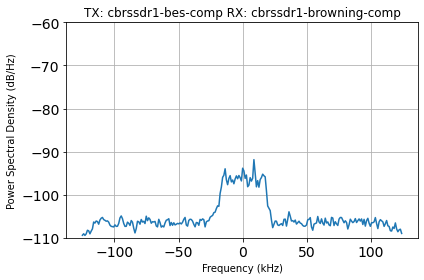

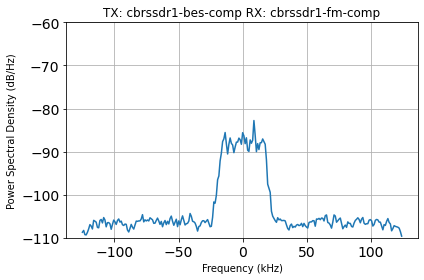

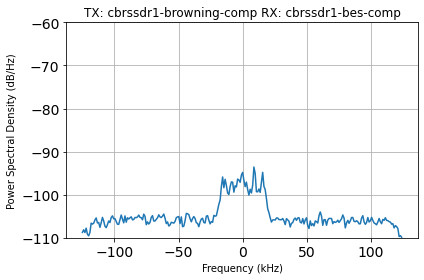

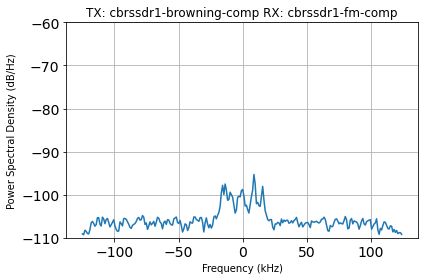

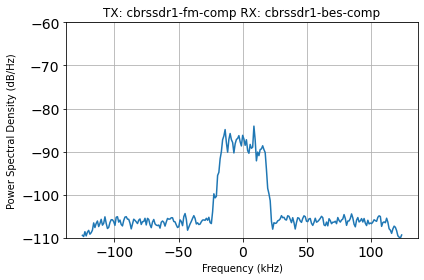

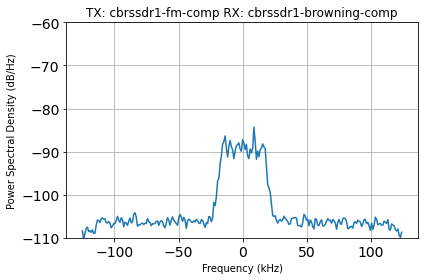

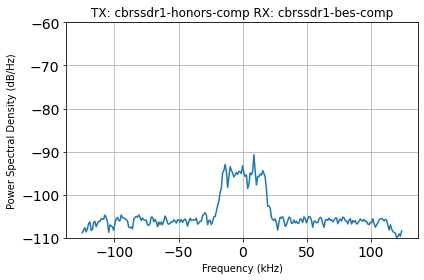

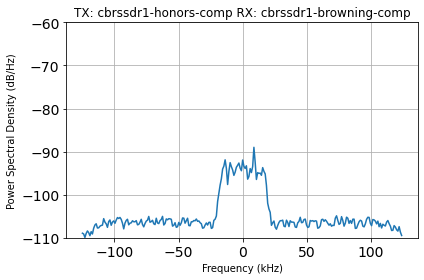

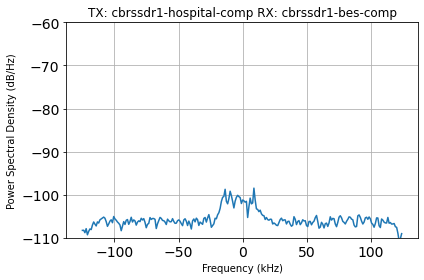

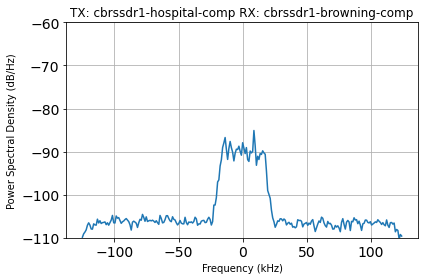

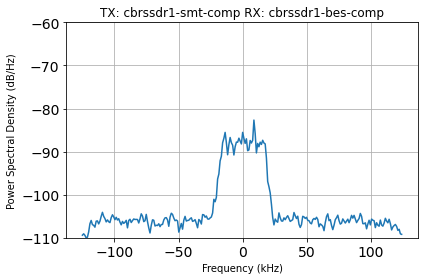

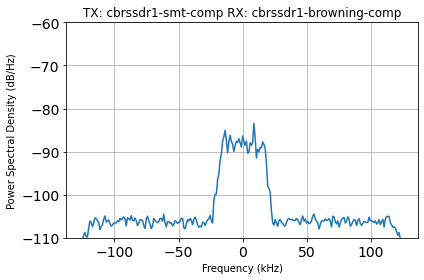

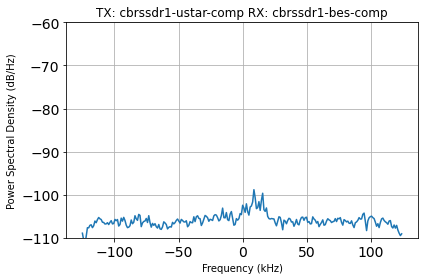

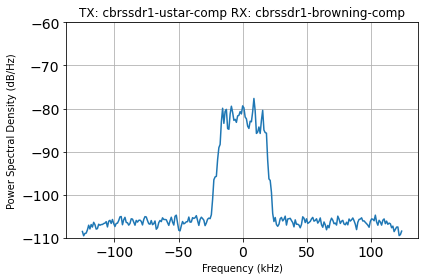

In [7]:
####################
# PSD PLT PER LINK #
####################

# plotting PSD for every link with repNum = 0

plotOnePSDForEachLink(rx_data, txrxloc, samp_rate)

 ----- Lag data written to files ----- 
 ----- SNR data written to files ----- 
Packet Length: 4072


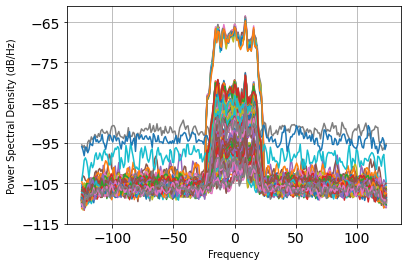

In [8]:
####################
# CALCULATE LAGS   #
####################

A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6

lag_data = []
snr_data = []
peaks_arr = []

for tx in rx_names:
    for rx in rx_names:
        if tx != rx:
            lags_row = []
            snr_row = []
            for repNum in range(4):
                # pick tx - rx pair
                txloc = 'cbrssdr1-' + tx + '-comp'
                rxloc = 'cbrssdr1-' + rx + '-comp'

                rx_data[txloc] = np.vstack(rx_data[txloc])
                rxloc_arr = np.array(txrxloc[txloc])
                rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]

                # Low Pass Filtering to out_of_band frequency components
                stopband_attenuation = 60.0
                transition_bandwidth = 0.05
                cutoff_norm = 0.15
                filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
                taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
                filtered_rx0 = signal.lfilter(taps, 1.0, rx0)
                
                preambleSignal, pulse = createPreambleSignal(A, N, alpha, Lp)
                lagIndex = crossCorrelationMax(filtered_rx0, preambleSignal, peaks_arr)
                snr = calculate_SNR(rx0)
                
                lags_row.append(lagIndex)
                snr_row.append(snr)
            lag_data.append(lags_row)
            snr_data.append(snr_row)

lag_data = np.array(lag_data)
snr_data = np.array(snr_data)
off = 4072

for r in range(4):
    file_name = 'col_' + str(r+1) + '.txt'
    with open(file_name,'w') as f:
        for dat in lag_data[:,r]:
            f.write(str(dat) + ',\n')

print(' ----- Lag data written to files ----- ')

for r in range(4):
    file_name = 'snr_' + str(r+1) + '.txt'
    with open(file_name,'w') as f:
        for dat in snr_data[:,r]:
            f.write(str(dat) + ',\n')

print(' ----- SNR data written to files ----- ')
print("Packet Length:", off)

In [9]:
####################
# SETTING UP A     #
####################

A = np.zeros((len(links),2*len(rx_names)))

# delta is a vector of the sample number of the start of the sync in the recieved signal
link_num = 0
for link in links:
    # each link is a (tx_name, rx_name)
    tx_num = rx_names.index(link[0])
    rx_num = rx_names.index(link[1])
    A[link_num,tx_num] = 1
    A[link_num,len(rx_names)+tx_num] = 1
    A[link_num,rx_num] = -1
    link_num += 1

print(" ----- A matrix ----- ")
# print(A)

 ----- A matrix ----- 


In [10]:
####################
# FIND PEUSDO-INV  #
####################

pinvA = np.linalg.pinv(A)

print(" ----- peusdoinverse A ----- ")
# print(pinvA)

 ----- peusdoinverse A ----- 


In [11]:
####################
# MAKE DELTA VECS  #
####################

delta_1 = make_delta(1,links)
delta_2 = make_delta(2,links)
delta_3 = make_delta(3,links)
delta_4 = make_delta(4,links)

In [12]:
####################
# MAKE SNR VECS    #
####################

snr_1 = make_snr_vecs(1,links)
snr_2 = make_snr_vecs(2,links)
snr_3 = make_snr_vecs(3,links)
snr_4 = make_snr_vecs(4,links)

m_snr_1 = max(snr_1)
m_snr_2 = max(snr_2)
m_snr_3 = max(snr_3)
m_snr_4 = max(snr_4)

snr_1 = snr_1 / m_snr_1
snr_2 = snr_2 / m_snr_2
snr_3 = snr_3 / m_snr_3
snr_4 = snr_4 / m_snr_4

In [13]:
####################
# CORRECT ERR EST  #
####################

# Comment out this section to see results if
# data is not corrected for wrap around lag

print(' ----- Values to Correct ----- ')
delta_1 = correct_difference(1,delta_1,rx_names,off)
delta_2 = correct_difference(2,delta_2,rx_names,off)
delta_3 = correct_difference(3,delta_3,rx_names,off)
delta_4 = correct_difference(4,delta_4,rx_names,off)

 ----- Values to Correct ----- 
Column 2, Section 5, Index 2 -- 737.0
Column 3, Section 5, Index 2 -- 936.0


In [14]:
####################
# RUNNING ALL COLS #
####################

e_est_1, T_est_1, estimate_1 = find_e_vector(delta_1,pinvA,rx_names)
e_est_2, T_est_2, estimate_2 = find_e_vector(delta_2,pinvA,rx_names)
e_est_3, T_est_3, estimate_3 = find_e_vector(delta_3,pinvA,rx_names)
e_est_4, T_est_4, estimate_4 = find_e_vector(delta_4,pinvA,rx_names)

In [15]:
####################
# PRINTING COLS    #
####################

print_results(1, rx_names, e_est_1, T_est_1)
print('\n ------------------------------ \n')

print_results(2, rx_names, e_est_2, T_est_2)
print('\n ------------------------------ \n')

print_results(3, rx_names, e_est_3, T_est_3)
print('\n ------------------------------ \n')

print_results(4, rx_names, e_est_4, T_est_4)
print('\n ------------------------------ \n')

 ---------- column (repNum) 1 in delta data ---------- 
(~, rx_name ) -----    e_estimate    -----   T_estimate
(~, bes     ) -----  [131.74285714]  ----- [2728.96666667]
(~, browning) -----  [133.40000000]  ----- [1813.36666667]
(~, fm      ) -----  [-797.4571429]  ----- [1894.3666667]
(~, honors  ) -----  [133.42857143]  ----- [1952.16666667]
(~, hospital) -----  [133.17142857]  ----- [953.96666667]
(~, smt     ) -----  [131.74285714]  ----- [1201.96666667]
(~, ustar   ) -----  [133.97142857]  ----- [2374.36666667]

 ------------------------------ 

 ---------- column (repNum) 2 in delta data ---------- 
(~, rx_name ) -----    e_estimate    -----   T_estimate
(~, bes     ) -----  [132.68571429]  ----- [2936.03333333]
(~, browning) -----  [132.68571429]  ----- [2025.03333333]
(~, fm      ) -----  [-796.6571429]  ----- [4565.4333333]
(~, honors  ) -----  [135.57142857]  ----- [2158.83333333]
(~, hospital) -----  [130.94285714]  ----- [1167.23333333]
(~, smt     ) -----  [131.08571429] 

 ----- Plotting Link Weighted Error for Column 1 ----- 


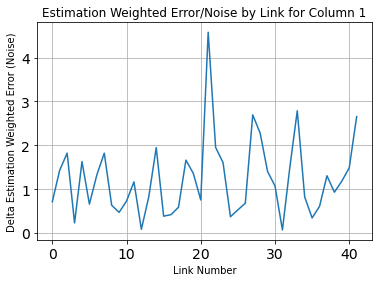

 ----- Histogram Link weighted error for Column 1 ----- 


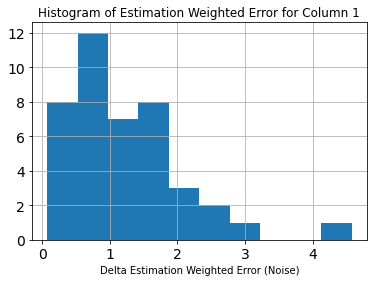

 ----- Histogram Link Squared Weighted Error for Column 1 ----- 


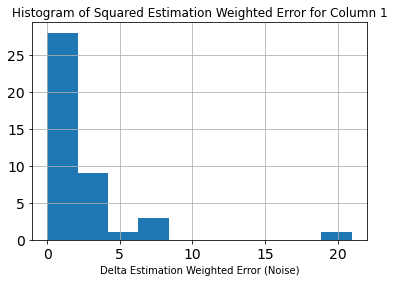

 ----- Root Mean Squared Weighted Error for Column 1 ----- 
1.5056067128821078


 ----- Plotting Link Weighted Error for Column 2 ----- 


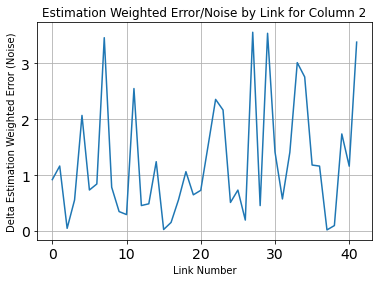

 ----- Histogram Link weighted error for Column 2 ----- 


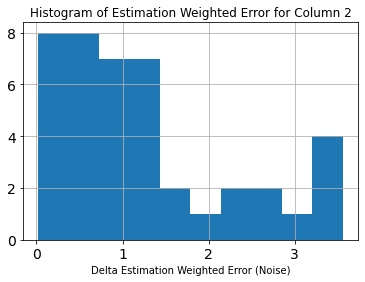

 ----- Histogram Link Squared Weighted Error for Column 2 ----- 


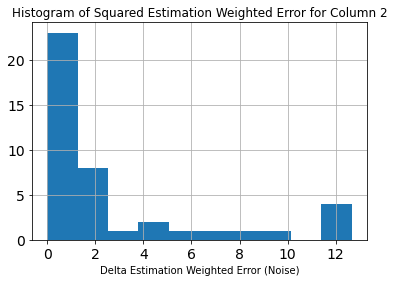

 ----- Root Mean Squared Weighted Error for Column 2 ----- 
1.6196432955691118


 ----- Plotting Link Weighted Error for Column 3 ----- 


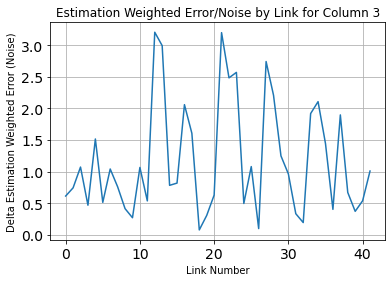

 ----- Histogram Link weighted error for Column 3 ----- 


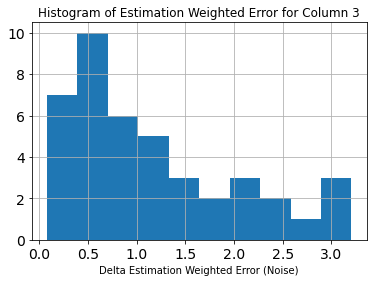

 ----- Histogram Link Squared Weighted Error for Column 3 ----- 


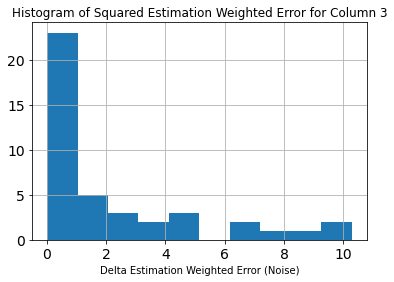

 ----- Root Mean Squared Weighted Error for Column 3 ----- 
1.4754434543577861


 ----- Plotting Link Weighted Error for Column 4 ----- 


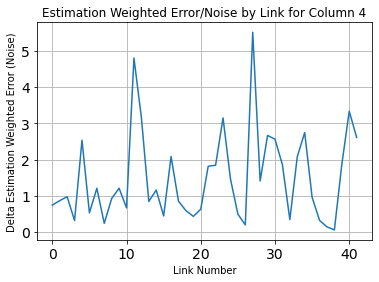

 ----- Histogram Link weighted error for Column 4 ----- 


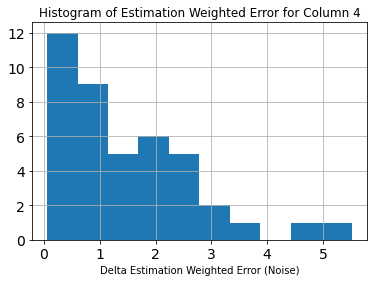

 ----- Histogram Link Squared Weighted Error for Column 4 ----- 


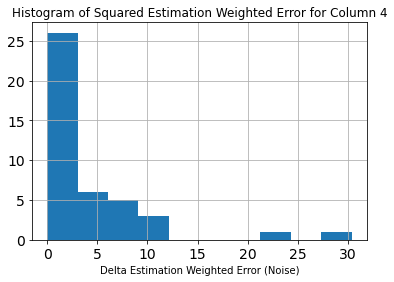

 ----- Root Mean Squared Weighted Error for Column 4 ----- 
1.9363769688774406




In [16]:
####################
# LEAST SQUARE ERR #
####################

# Error should be Gaussian
# Squared error histogram should be comparable to Chi Squared Distribution
# Link with example Chi Squared Distribution: https://www.stat.berkeley.edu/~stark/Java/Html/SampleChi.htm

## ======= Uncomment this section to analyze least square error ======= ##
# RMSE_1 = least_sq_error(1,estimate_1,delta_1,A,links)
# RMSE_2 = least_sq_error(2,estimate_2,delta_2,A,links)
# RMSE_3 = least_sq_error(3,estimate_3,delta_3,A,links)
# RMSE_4 = least_sq_error(4,estimate_4,delta_4,A,links)

## ======= Uncomment this section to analyze weighted least square error ======= ##
RMSE_1 = w_least_sq_error(1,estimate_1,delta_1,snr_1,A,links)
RMSE_2 = w_least_sq_error(2,estimate_2,delta_2,snr_2,A,links)
RMSE_3 = w_least_sq_error(3,estimate_3,delta_3,snr_3,A,links)
RMSE_4 = w_least_sq_error(4,estimate_4,delta_4,snr_4,A,links)

column 1 ----- column 2 ----- column 3 ----- column 4
1.505607 ----- 1.619643 ----- 1.475443 ----- 1.936377

RMSE ratio between columns:  0.7619606099432084


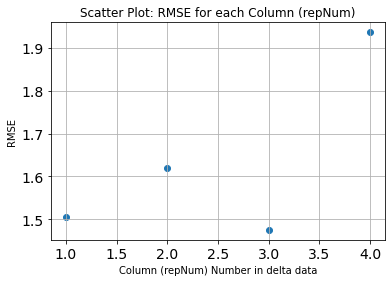

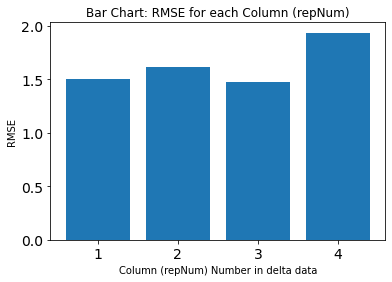

In [17]:
####################
# PRINTING COLS    #
####################

RMSE_1 = round_string(RMSE_1)
RMSE_2 = round_string(RMSE_2)
RMSE_3 = round_string(RMSE_3)
RMSE_4 = round_string(RMSE_4)

RMSE_ratio = min([RMSE_1, RMSE_2, RMSE_3, RMSE_4])/max([RMSE_1, RMSE_2, RMSE_3, RMSE_4])

print(Fore.RED + "column 1 ----- column 2 ----- column 3 ----- column 4" + Style.RESET_ALL)
print(str(RMSE_1) + ' ----- ' + str(RMSE_2) + ' ----- ' + str(RMSE_3) + ' ----- ' + str(RMSE_4))
print('\nRMSE ratio between columns: ', RMSE_ratio)

plt.scatter(np.array([1,2,3,4]),np.array([RMSE_1,RMSE_2,RMSE_3,RMSE_4]))
plt.grid()
plt.xlabel('Column (repNum) Number in delta data')
plt.ylabel('RMSE')
plt.title('Scatter Plot: RMSE for each Column (repNum)')
plt.show()

plt.bar(np.array(['1','2','3','4']),np.array([RMSE_1,RMSE_2,RMSE_3,RMSE_4]))
plt.xlabel('Column (repNum) Number in delta data')
plt.ylabel('RMSE')
plt.title('Bar Chart: RMSE for each Column (repNum)')
plt.show()

In [18]:
####################
# RMSE RESULTS     #
####################

# ================================================================= #
# ======================== Feb 16 Data ============================ #
# ================================================================= #

##### Un-corrected #####

# Un-corrected Root Mean Squared Errors for Feb 16 Data
# 3.544486 ----- 521.1848 ----- 522.2963 ----- 4.148067

# Un-corrected RMSE Ratio between columns for Feb 16 Data
# 0.0067863509659172394 : off=4072

##### Corrected #####

# Corrected Root Mean Squared Errors for Feb 16 Data
# 3.544486 ----- 5.453213 ----- 4.501851 ----- 4.148067 : off=4096
# 3.544486 ----- 3.811383 ----- 3.450722 ----- 4.148067 : off=4072

# Corrected RMSE Ratio between columns for Feb 16 Data
# 0.8318867559275199 : off=4072

##### Corrected Weighted #####

# Corrected Weighted Root Mean Squared Errors for Feb 16 Data
# 1.505607 ----- 1.619643 ----- 1.475443 ----- 1.936377 : off=4072

# Corrected Weighted RMSE Ratio between columns for Feb 16 Data
# 0.7619606099432084 : off=4072

# ================================================================= #
# ======================== Jan 20 Data ============================ #
# ================================================================= #

##### Un-corrected #####

# Un-corrected Root Mean Squared Errors for Jan 20 Data
# 876.1062 ----- 521.5538 ----- 928.9545 ----- 1145.608

# Un-corrected RMSE Ratio between columns for Jan 20 Data
# 0.45526375514137474 : off = 4072

##### Corrected #####

# Corrected Root Mean Squared Errors for Jan 20 Data
# 6.917296 ----- 4.854248 ----- 7.513442 ----- 7.276753 : off=4096
# 3.629246 ----- 3.262513 ----- 3.947286 ----- 4.431655 : off=4072

# Corrected RMSE Ratio between columns for Jan 20 Data
# 0.736183886155398 : off = 4072

##### Corrected Weighted #####

# Corrected Weighted Root Mean Squared Errors for Jan 20 Data
# 1.625313 ----- 1.625661 ----- 1.887089 ----- 1.866277 : off=4072

# Corrected Weighted RMSE Ratio between columns for Jan 20 Data
# 0.8612805225402723 : off = 4072